In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


# === Dataförberedelse ===

base_dir = "brain_tumor_dataset"
seed = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=seed
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


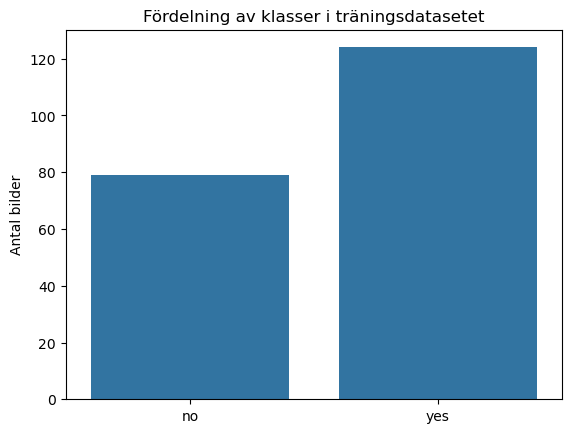

In [50]:
# === Visa klassfördelning ===

sns.barplot(
    x=list(train_generator.class_indices.keys()), 
    y=[sum(train_generator.classes == v) for v in train_generator.class_indices.values()]
)
plt.title("Fördelning av klasser i träningsdatasetet")
plt.ylabel("Antal bilder")
plt.show()

In [51]:
# === Hantera obalanserade klasser ===

cw_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(cw_arr))
print("Class Weights:", class_weights)

Class Weights: {0: 1.2848101265822784, 1: 0.8185483870967742}


In [52]:
# === Bygg modellen Transfer Learning med MobileNetV2 ===

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

# Frys bara de första 60 lagren
for layer in base_model.layers[:60]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [53]:
# === Träning ===

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/50


c:\Users\olive\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.6453 - loss: 0.7284 - val_accuracy: 0.3800 - val_loss: 1.9172
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7931 - loss: 0.4632 - val_accuracy: 0.4400 - val_loss: 2.0570
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.8325 - loss: 0.3267 - val_accuracy: 0.4200 - val_loss: 1.8896
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8818 - loss: 0.3484 - val_accuracy: 0.5400 - val_loss: 1.2879
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8966 - loss: 0.2340 - val_accuracy: 0.6800 - val_loss: 0.8839
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9360 - loss: 0.1605 - val_accuracy: 0.6600 - val_loss: 1.0322
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9458 - loss: 0.1866 - val_accuracy: 0.6600 - val_loss: 1.0748
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9261 - loss: 0.1577 - val_accuracy: 0.7000 - val_loss: 1.0461
Ep

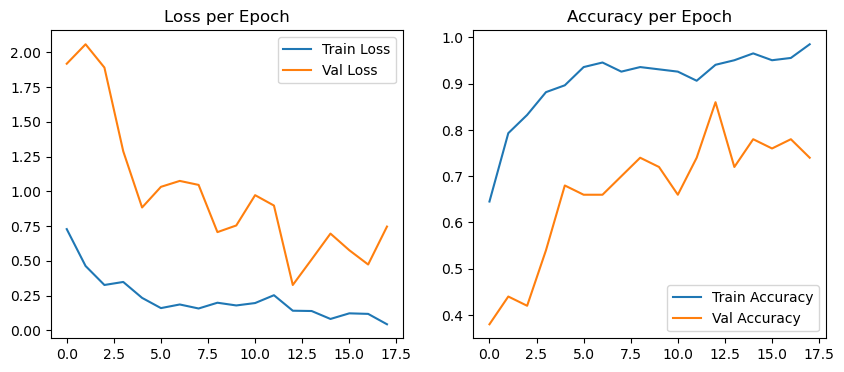

In [54]:
# === Utvärdering ===

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 974ms/step
Classification Report:
              precision    recall  f1-score   support

          no       0.65      0.89      0.76        19
         yes       0.92      0.71      0.80        31

    accuracy                           0.78        50
   macro avg       0.79      0.80      0.78        50
weighted avg       0.82      0.78      0.78        50



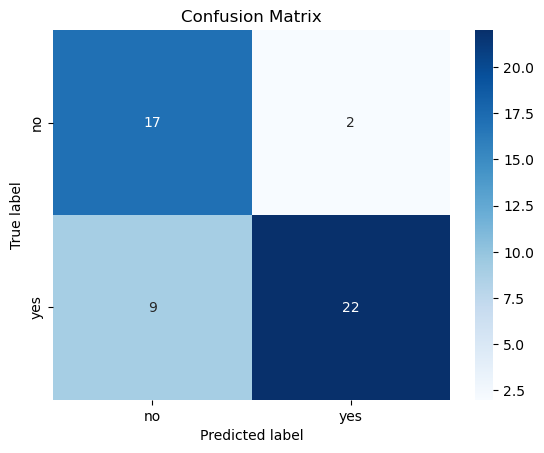

In [55]:
# === Klassificeringsrapport och Confusion Matrix ===

Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(val_generator.classes, y_pred, target_names=list(val_generator.class_indices.keys())))

cm = confusion_matrix(val_generator.classes, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(val_generator.class_indices.keys()),
    yticklabels=list(val_generator.class_indices.keys())
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()